In [57]:
# Necessary libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split , GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler , MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import joblib
import os


In [58]:
df = pd.read_csv('../data/heart_disease.csv')
df.head()

,PC1,PC7,PC5,PC2,PC10,PC4,PC6,target
0,-1.142929,-0.176824,0.876139,0.304724,0.912271,0.158837,0.595961,0
1,-2.754957,-0.803580,-0.784552,0.839171,-0.236447,0.662535,0.343510,1
2,-2.227239,0.727509,0.701716,-1.063098,0.172939,-0.004591,0.722079,1
3,1.140714,-0.620638,1.395045,-0.565884,-0.182818,-2.411838,-0.672393,0
4,1.701610,-0.685079,0.262726,-0.278171,-0.073178,-0.592310,0.785178,0


In [59]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42 , 
    stratify=y
    )

In [60]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),   
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True)
}

In [61]:
parameters = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100] , 
        'solver': ['liblinear', 'saga'], 
        'penalty': ['l1', 'l2']
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 15, 20] , 
        'min_samples_split': [2, 5, 10], 
        'min_samples_leaf': [1, 2, 4]
        },
    'Random Forest': {
        'n_estimators': [50, 100, 200], 
        'max_depth': [None, 5, 10] , 
        'min_samples_split': [2, 5, 10], 
        'min_samples_leaf': [1, 2, 4]
        },
    'Support Vector Machine': {
        'C': [0.01, 0.1, 1, 10], 
        'kernel': ['linear', 'rbf'], 
        'gamma': ['scale', 'auto']
        }
} 

In [62]:
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        model, 
        parameters[model_name], 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[model_name] = {
        'Best Parameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"{model_name} - Best ROC AUC: {grid_search.best_score_:.4f}\n")


Training Logistic Regression...
Logistic Regression - Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression - Accuracy: 0.8000, Precision: 0.8333, Recall: 0.7143, F1 Score: 0.7692
Logistic Regression - Best ROC AUC: 0.9131

Training Decision Tree...
Decision Tree - Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Decision Tree - Accuracy: 0.7167, Precision: 0.7391, Recall: 0.6071, F1 Score: 0.6667
Decision Tree - Best ROC AUC: 0.7895

Training Random Forest...
Random Forest - Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Random Forest - Accuracy: 0.8500, Precision: 0.9130, Recall: 0.7500, F1 Score: 0.8235
Random Forest - Best ROC AUC: 0.9013

Training Support Vector Machine...
Support Vector Machine - Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Support Vector Machine - Accuracy: 0.8500, Precision: 0.9130, Recall: 0.7500, F1 Score: 0.8235
Supp

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Support Vector Machine...


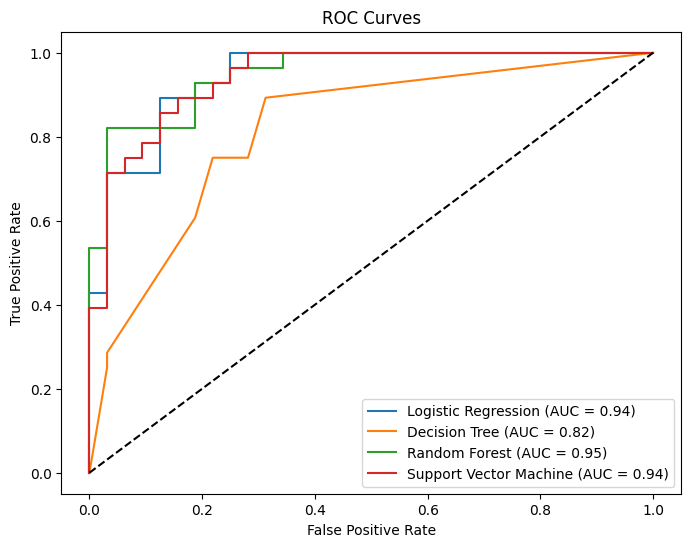

In [63]:
import joblib
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

roc_results = []
best_auc = 0
best_model_name = None
best_model_final = None

plt.figure(figsize=(8,6))
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    grid_search = GridSearchCV(
        model, 
        parameters[model_name], 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_results.append((model_name, fpr, tpr, roc_auc))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_model_name = model_name
        best_model_final = best_model

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [64]:
#Save the best model
os.makedirs('../models', exist_ok=True)
joblib.dump(best_model_final, f'../models/final_model.pkl')
print(f"Best model '{best_model_name}' saved with AUC = {best_auc:.2f}")

Best model 'Random Forest' saved with AUC = 0.95
